In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64
import math
import warnings
warnings.filterwarnings('ignore')

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 05: Processos Gaussianos para regressão

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

Text(0.5, 1.0, 'GP posterior')

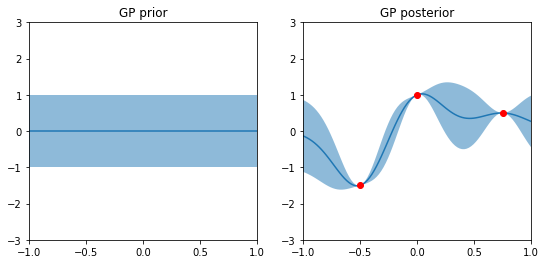

In [3]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0, s2=s2):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)
    
    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')


Vamos experimentar um pouco o código, criando plots para diferentes valores de $c$ e $gamma$.

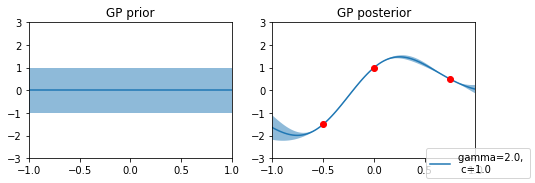

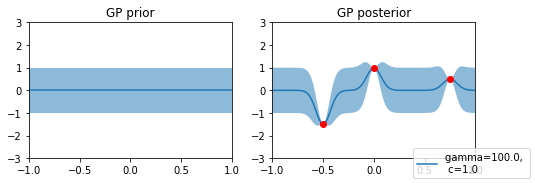

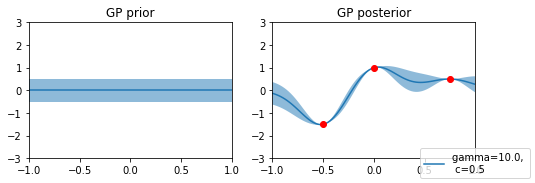

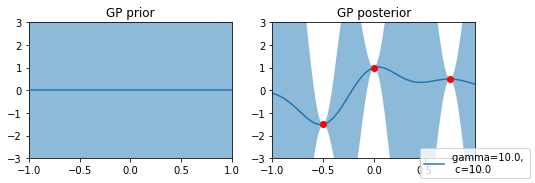

In [4]:
for gamma, c in [(2.0, 1.0), (100.0, 1.0), (10.0, 0.5), (10.0, 10.0)]:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))

    K = rbf_kernel(x, x, gamma, c) + torch.eye(x.shape[0])*s2
    mu = torch.zeros_like(x)

    axs[0].plot(x, mu)
    axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
    axs[0].set_xlim([-1, 1])
    axs[0].set_ylim([-3, 3])
    axs[0].set_title('GP prior')

    post_mu, post_cov = posterior_pred(x, xtrain, ytrain, gamma, c)
    axs[1].plot(x, post_mu)
    axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
    axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

    axs[1].set_xlim([-1, 1])
    axs[1].set_ylim([-3, 3])
    axs[1].set_title('GP posterior')

    # make legend with gamma and c
    fig.legend(['gamma={:.1f}, \n c={:.1f}'.format(gamma, c)], loc='lower right')

Alterar o gamma da função de kernel altera a suavidade da função da posteriori, isto é, torna as curvas (média) e sombreados (desvio padrão) menos ou mais suaves. Quando aumentamos muito gamma, definindo $gamma=1000$, por exemplo, a curva se torna quase uma reta em zero, sendo alterada apenas para alcançar os pontos. Tornar gamma próximo demais de 0 faz com que a curva se adapte demais aos dados, quase anulando o desvio padrão. No entanto, alterar o gamma não tem influência na priori! É interessante observar que o gamma utilizado no código é o inverso do lengthscale, isto é, na fórmula do kernel, $\sigma^2 \exp\left(-\frac{|x-x'|^2}{2l^2}\right)$, o gamma é $\frac{1}{2l^2}$.

Alterar o parâmetro $c$ da função de kernel altera tanto a priori quanto a posteriori. Na priori, alterar o $c$ significa alterar diretamente o sombreado do desvio padrão, que tem amplitude igual a $2c$, isto é, um $c$ para baixo da média e um para cima. amplitude da função da posteriori, isto é, torna as curvas (média) e sombreados (desvio padrão) mais ou menos amplas. Na posteriori, temos uma influência bem parecida, a média se mantém a mesma e o desvio padrão é alterado (note que $c$ é o próprio desvio padrão), também passando a variar entre valores próximos a $+c$ e $-c$, mas se adaptando mais aos dados, isto é, reduzindo perto dos pontos e aumentando entre eles.

**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [5]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

Queremos escolher os hiperparâmetros para nosso GP, para isso, vamos começar decidindo os hiperparâmetros iniciais para gamma e $c$, utilizando heurísticas. Escolhi utilizar uma heurística sugerida no link do Infallible Thompson, deixado pelo professor no eclass, e como sabemos que não há mínimo global, utilizei as divisões das heurísticas (normalmente escolhe-se um valor inteiro variando entre 1 e 10 para gamma e 2 e 100 para $c$) como vários pontos de partida, escolhendo diferentes valores, dentro dessas variações, para inicializar $gamma$ e $c$. Tratamos, também, $c$ por sigma2_f, e a variância do ruído por sigma2_n.

Depois de escolher as heurísticas e inicializá-los, definimos as funções necessárias (kernel, loss e otimizador), para então aplicar. Fazemos, de fato, início em diversos starting points escolhendo esses os hiperparâmetros, aplicamos o otimizador e seguimos escolhendo a menor das losses, guardando os hiperparâmetros que a geraram. No final, temos os hiperparâmetros ótimos.

In [25]:
# define initial parameters with heuristics
gamma_division_values = torch.linspace(1, 10, 10) # gamma should vary from being divided by 2 to 100
sigma2_n_division_values = torch.linspace(2, 100, 15) # sigma_n should vary from being divided by 2 to 100
sigma2_f = torch.var(torch.tensor(train_y))
best_loss = np.inf

# rbf kernel
def rbf_kernel(x1, x2, gamma, sigma2_f):
    x1 = torch.tensor(x1)
    x2 = torch.tensor(x2)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*sigma2_f

# loss function
def loss(X, y, gamma, sigma2_f, sigma2_n):
    X = torch.tensor(X)
    y = torch.tensor(y)
    K = rbf_kernel(X, X, gamma, sigma2_f)
    return -0.5*torch.logdet(K + (sigma2_n*torch.eye(len(X)))) - 0.5*(y.T @ torch.inverse(K + (sigma2_n*torch.eye(len(X)))) @ y)

# train model
def optimizer(X, y, gamma, sigma2_f, sigma2_n):
    opt = torch.optim.Adam([gamma, sigma2_f, sigma2_n], lr=0.001)
    losses = []
    gammas = []
    sigma2_ns = []
    sigma2_fs = []
    
    for i in range(200):
        gammas.append(gamma.item())
        sigma2_ns.append(sigma2_n.item())
        sigma2_fs.append(sigma2_f.item())
        opt.zero_grad()
        updated_loss = -1 * loss(X, y, gamma, sigma2_f, sigma2_n)
        losses.append(updated_loss.item())

        updated_loss.backward()
        opt.step()
    
    return losses, gammas, sigma2_ns, sigma2_fs

sigma2_f.requires_grad = True

# train model using multiple starting points for gamma and sigma2_n
for gamma_division_value in gamma_division_values:
    for sigma2_n_division_value in sigma2_n_division_values:

        # initialize parameters
        gamma = gamma_division_value/(2 * torch.std(torch.tensor(train_X)))
        gamma.requires_grad = True
        sigma2_n = torch.sqrt(sigma2_f).detach()/sigma2_n_division_value
        sigma2_n.requires_grad = True

        # apply optimizer
        losses, gammas, sigma2_ns, sigma2_fs = optimizer(train_X, train_y, gamma, sigma2_f, sigma2_n)

        # check if loss is better than previous best
        if losses[-1] < best_loss:
            best_loss = losses[-1]
            best_loss_vector = losses

            # save best parameters vectors
            best_gammas = gammas
            best_sigma2_ns = sigma2_ns
            best_sigma2_fs = sigma2_fs

Vamos plotar a loss através das iterações:

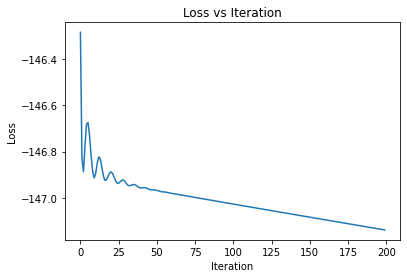

In [26]:
# plot loss
plt.plot(losses)
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Vejamos a evidência obtida:	

In [27]:
# evidence
evidence = loss(train_X, train_y, best_gammas[-1], best_sigma2_fs[-1], best_sigma2_ns[-1])
print('Evidence: ', float(evidence.detach()))

Evidence:  147.1762749259191


E vejamos o vetor de losses escolhido, assim como os hiperparâmetros que o geraram:

In [28]:
gamma = best_gammas[-1]
var_noise = best_sigma2_ns[-1]
c = best_sigma2_fs[-1]  
loss_vec = best_loss_vector

print('gamma: ', gamma)
print('c: ', c)
print('variância do ruído: ', var_noise)
print('loss: ', loss_vec)

gamma:  10.381698097500038
c:  0.8327156143957172
variância do ruído:  0.010380541912552386
loss:  [-83.63070172523108, -83.99908089313182, -84.37053792272528, -84.74517694902096, -85.12310234979365, -85.50442723503849, -85.88926239181797, -86.27772480976243, -86.6699321318344, -87.06601438981221, -87.46609385404489, -87.870305548678, -88.27878277187696, -88.69166915186644, -89.1091037884574, -89.53123959005346, -89.95822517629014, -90.39022357628167, -90.82739699468318, -91.26990997129522, -91.71793922025063, -92.17166438586405, -92.6312681734263, -93.09694652737946, -93.56889577235302, -94.04731944540771, -94.53243211035475, -95.024456435669, -95.52362007878416, -96.03015950001526, -96.54432403287187, -97.06636927527583, -97.5965647975626, -98.1351874366086, -98.68252924095773, -99.23889449990158, -99.80460042565622, -100.37997788035565, -100.96537215085922, -101.5611478058178, -102.16768575943472, -102.78538422552523, -103.41465973394953, -104.05595246968653, -104.70972341119915, -1

E plots comparando a priori e a posteriori:

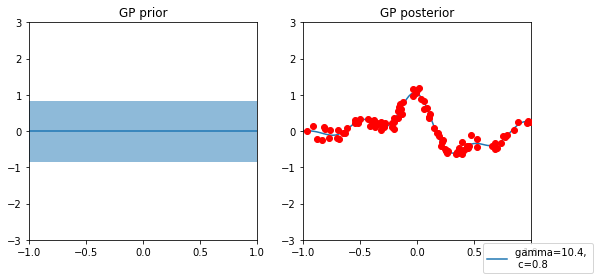

In [29]:
# plot prior and posterior
x = torch.linspace(-1, 1, 100)[:, None]
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

K = rbf_kernel(x, x, gamma, c) + torch.eye(x.shape[0])*var_noise
mu = torch.zeros_like(x)

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')

post_mu, post_cov = posterior_pred(x, torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32), gamma, c, var_noise)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(train_X, train_y, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')

# make legend with gamma and c
fig.legend(['gamma={:.1f}, \n c={:.1f}'.format(gamma, c)], loc='lower right')

Reportaremos, ainda, a log verossimilhança e o MSE com relação à média para o conjunto de teste

In [30]:
# log marginal likelihood
log_marginal_likelihood = loss(test_X, test_y, gamma, c, var_noise)
print('Log marginal likelihood: ', log_marginal_likelihood.item())

# mse 
test_mean, test_cov = posterior_pred(torch.tensor(test_X, dtype=torch.float32), torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32), gamma, c, var_noise)
mse = torch.mean((test_mean - torch.tensor(test_y, dtype=torch.float32))**2)
print('MSE: ', mse.item())

Log marginal likelihood:  871.5346305656244
MSE:  0.009945918805897236


# Exercício de "papel e caneta"

**1.** Na nota de aula, derivamos a posteriori preditiva $p(y_\star | x_\star, x_1, y_1, \ldots, x_N, y_N)$. Por simplicidade, deduzimos a priori preditiva $p(y_\star, y_1, \ldots, y_N | x_\star, x_1, \ldots, x_N)$ e as condicionamos nas saídas $y_1, \ldots, y_N$ observadas no conjunto de treino. No entanto, também é possível obter o mesmo resultado calculando a posteriori $p(f_\star, f_1, \ldots, f_N | x_\star, x_1, \ldots, x_N)$ e, então, calculando o valor esperado de $p(y_\star | x_\star, f_\star)$ sob essa posteriori. Deduza novamente a posteriori preditiva seguindo esse outro procedimento.

Estamos buscando a posteriori preditiva $p(y_\star|y, x, x_\star)$, que sabemos que pode ser escrita por:

$$p(y_\star|y, x, x_\star) = \int p(y_\star| f_\star, x, x_\star) p(f_\star| y, x, x_\star) df_\star$$

Buscaremos, a partir de agora, trabalhar para encontrar a distribuição de dessas duas partes. Vamos iniciar buscando a distribuição de $p(f_\star| y, x, x_\star)$. Vamos partir de $p(f_\star, f, y| x, x_\star)$, que pode ser escrita como:

$$p(f_\star, f, y| x, x_\star) = p(f_\star| f, x, x_\star) p(f | x) p(y|f)$$

Em que cada uma dessas distribuições é gaussiana. Assim, temos:

$$
\left[ 
\begin{matrix}
f_\star \\ f \\ y
\end{matrix}
\right]
\sim
\mathcal{N}\left(
\left[
\begin{matrix}
\mu(f_\star) \\ \mu(f) \\ \mu(y)
\end{matrix}
\right]
,
\Sigma
\right)
=
\mathcal{N}\left(
\left[
\begin{matrix}
0\\ 0 \\ 0
\end{matrix}
\right]
,
\Sigma
\right)
$$

Em que $\Sigma$ é a matriz de covariâncias, que pode ser escrita como:

$$
\Sigma =
\left[
\begin{matrix}
cov(f_\star, f_\star) & cov(f_\star, f) & cov(f_\star, y) \\
cov(f, f_\star) & cov(f, f) & cov(f, y) \\
cov(y, f_\star) & cov(y, f) & cov(y, y)
\end{matrix}
\right]
=
\left[
\begin{matrix}
k(x_\star, x_\star) & k(x_\star, x) & cov(f_\star, y) \\
k(x, x_\star) & k(x, x) & cov(f, y) \\
cov(y, f_\star) & cov(y, f) & var(y)
\end{matrix}
\right]
$$

Portanto:

$$
\left[ 
\begin{matrix}
f_\star \\ f \\ y
\end{matrix}
\right]
\sim
\mathcal{N}\left(
\left[
\begin{matrix}
0 \\ 0 \\0
\end{matrix}
\right]
,
\left[
\begin{matrix}
k(x_\star, x_\star) & k(x_\star, x) & cov(f_\star, y) \\
k(x, x_\star) & k(x, x) & cov(f, y) \\
cov(y, f_\star) & cov(y, f) & var(y)
\end{matrix}
\right]
\right)
$$

No entanto, como buscamos a distribuição de $p(f_\star| y, x, x_\star)$, vamos começar marginalizando $f$:

$$p(f_\star, y| x, x_\star) = \int p(f_\star,f, y| x, x_\star)df$$

Para isso, conforme discutido em aula, nos livramos dos termos envolvendo $f$ na matriz de covariâncias, e temos:

$$
\left[
\begin{matrix}
f_\star \\ y
\end{matrix}
\right]
\sim
\mathcal{N}\left(
\left[
\begin{matrix}
0 \\ 0
\end{matrix}
\right]
,
\left[
\begin{matrix}
k(x_\star, x_\star) & cov(f_\star, y) \\
cov(y, f_\star) & var(y)
\end{matrix}
\right]
\right)
$$

Temos interesse, ainda, em condicionar essa distribuição em $y$. Utilizaremos nossa matriz de covariâncias, por isso tentaremos simplificar as entradas. Vejamos $cov(f_\star, y) = cov(y, f_\star) = \mathbb{E}_{f_\star, y} [(f_\star - \mathbb{E}[f_\star]) (y - \mathbb{E}[y]^T )]$. Como $y = f + \epsilon$:

$$ \mathbb{E}_{f_\star,f + \epsilon} [(f_\star - \mathbb{E}[f_\star]) (y - \mathbb{E}[y]^T )] = $$
$$ \mathbb{E}_{f_\star,f + \epsilon} [(f_\star - \mathbb{E}[f_\star]) (f + \epsilon - \mathbb{E}[f_\star + \epsilon]^T )] =  $$
$$ \mathbb{E}_{f_\star,f + \epsilon} [(f_\star) (f + \epsilon - \mathbb{E}[f_\star + \epsilon]^T )] = $$
$$ \mathbb{E}_{f_\star,f + \epsilon} [(f_\star f  + f_\star \epsilon) ] =  $$
$$ \mathbb{E}_{f_\star,f + \epsilon} [f_\star f]  + \mathbb{E}_{f_\star,f + \epsilon} [f_\star \epsilon ] =  $$
$$ \mathbb{E}_{f_\star,f + \epsilon} [f_\star f] = k(x_\star, x) $$

Assim, temos que $cov(f_\star, y) = k(x_\star, x)$ e  
$$\left[ \begin{matrix} f_\star \\ y \end{matrix} \right] \sim \mathcal{N} \left( \left[ \begin{matrix} 0 \\ 0 \end{matrix} \right] , \left[ \begin{matrix} k(x_\star, x_\star) & k(x_\star, x) \\
k(x, x_\star) & var(y) \end{matrix} \right] \right) $$

Agora para termos $p(f_\star| y, x, x_\star)$, consideraremos que $y=y'$, em que $y'$ são observações de $y$. Assim, temos:
$$p(f_\star| y, x_\star, x) \sim N(\mu_\star, \Sigma_\star)$$

Com $\mu_\star = \mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y' - \mu_2 ) = k(x_\star, x) \Sigma(y)^{-1}y'$ e
$\Sigma_\star = \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21} = k(x_\star, x_\star) - k(x_\star, x)\Sigma(y)^{-1}k(x, x_\star)$

Assim, temos a distribuição de $p(f_\star| y, x, x_\star)$, sendo esta uma Normal com média $\mu_\star$ e variância $\Sigma_\star$. Vamos, então, calcular a distribuição de $p(y_\star| f_\star, x, x_\star)$, que com o truque mostrado em aula, sabemos ser equivalente a $p(f_\star| y_\star, x, x_\star)$, já que $f_\star$ é a média de $y_\star$. Isso é vantajoso para nós porque passamos a ter uma integral do produto de duas normais avaliadas na mesma variável, $f_\star$, o que nos permite utilizar a seguinte fórmula do Matrix Cookbook:

$$\mathcal{N}_{x}(m_1, \Sigma_1)\mathcal{N}_{x}(m_2, \Sigma_2) = c_c \mathcal{N}_{x}(m_c, \Sigma_c)$$

onde $c_c= \mathcal{N}_{m_1}(m_2, \Sigma_1+\Sigma_2)$. Assim, no nosso caso, teremos em \mathcal{N}_{x}(m_c, \Sigma_c) uma normal em função de $f_\star$, cuja integral é igual a 1. Nos resta, então, o termo $c_c$, que sairá da integral, resultando em:

$$p(y_\star|y, x, x_\star) = c_c = \mathcal{N}_{m_1}(m_2, \Sigma_1+\Sigma_2)$$

Onde $m_1$ e $\Sigma_1$ são, respectivamente, média e variância de $p(f_\star| y_\star, x, x_\star)$ e $m_2$, $\Sigma_2$ de $p(f_\star| y, x, x_\star)$ (que já conhecemos). Para sabermos o valor de $\Sigma_1$, lembramos que $p(f_\star| y_\star, x, x_\star)$ é equivalente a $p(y_\star| f_\star, x, x_\star)$, e com $f_\star$ dado, a variância depende apenas do ruído. Assim, $\Sigma_1 = Var(\epsilon) = \sigma^2$. Assim, fazendo as contas:

$$ m_2 =  k(x_\star, x) \Sigma(y)^{-1}y' = k(x_\star, x) (k(x, x)+\sigma^2 I)^{-1}y' $$
$$\Sigma_1 + \Sigma_2 = \sigma^2 +  k(x_\star, x_\star) - k(x_\star, x)\Sigma(y)^{-1}k(x, x_\star) = \sigma^2 +  k(x_\star, x_\star) - k(x_\star, x)(k(x, x)+\sigma^2 I)^{-1}k(x, x_\star) $$

E, portanto, a posteriori preditiva é dada por:
$$ p(y_\star|y, x, x_\star) = \mathcal{N}(\mu', \Sigma') $$
$$ \mu' = k(x_\star, x) (k(x, x)+\sigma^2 I)^{-1}y' $$
$$ \Sigma'  = \sigma^2 +  k(x_\star, x_\star) - k(x_\star, x)(k(x, x)+\sigma^2 I)^{-1}k(x, x_\star) $$

**2.** Quando trocamos a verossimilhança Gaussiana por uma Bernoulli (i.e., no caso de classificação binária), a posteriori para nosso GP não possui fórmula fechada. Mais especificamente, a verossimilhança para esse modelo é dada por $y | x \sim \text{Ber}(\sigma(f(x))$ onde $\sigma$ é a função sigmoide. Em resposta à falta de uma solução analítica, podemos aproximar a posteriori sobre $f$ para qualquer conjunto de pontos de entrada usando as técnicas de inferência aproximada que vimos anteriormente. Discuta como usar a aproximação de laplace nesse caso, incluindo as fórmulas para os termos da Hessiana. Além disse, discuta como usar o resultado desse procedimento para aproximar a posteriori preditiva.

Desejamos fazer uma classificação binária substituindo a verossimilhaça gaussiana por uma Bernoulli. Nesse caso, temos que $p(y=1|f)=\sigma(f)$, onde $y$ é uma variável que pertence a $\{0,1\}$ e $\sigma$ é a função sigmoide. Assim, a distribuição de prob é dada por:

$$
p(y|f)=\sigma(f)^y (1-\sigma(f))^{1-y}
$$

Essa será nossa verossimilhança. Buscamos calcular a probabilidade de uma nova entrada $y_\star$ ter um label, mas como a classificação é binária podemos avaliar arbitrariamente $p(y_\star=1|x, x_\star, y)$, que é dada por:

$$p(y_\star=1|x, x_\star, y) = \int p(y_\star=1| x_\star, y) p(f_\star|x, x_\star, y)df_\star $$

Como não há solução analítica, buscaremos aproximar essa posteriori para qualquer conjunto de pontos de entrada usando a aproximação de Laplace. Vamos começar avaliando a segunda parte dessa integral, $p(f_\star|x, x_\star, y)$:

$$ p(f_\star|x, x_\star, y) = \int p(f_\star|x, x_\star,f) p(f|x_\star, x, y) df$$

Já nessa integral, temos que a primeira parte $p(f_\star|x, x_\star,f)$ é uma normal obtida utilizando GP para regressão, e manipulando-a chegamos em $p(f_\star| f) \approx \mathcal{N}(0, k(x_\star, x_\star))$. 

Sabemos, ainda, que podemos escrever 
$$p(f, f_\star| x_\star, x) = \mathcal{N} \left( \left[ 
\begin{matrix} f \\ f_\star
\end{matrix} \right]| 
\left[
\begin{matrix} 0 \\ 0
\end{matrix} 
\right]
, 
\left[
\begin{matrix} k(x,x)+\sigma^2 I & k(x, x_\star) \\
k(x_\star, x) & k(x_\star, x_\star)
\end{matrix}
\right]\right)$$

Então a posteriori $p(f_\star| x, x_\star, y)$ é dada por uma $\mathcal{N}(\mu_\star, \Sigma_\star)$ onde
$$ \mu_\star = k(x_\star, x)(k(x,x)+\sigma_f^2I)^{-1}y
$$
$$\Sigma_\star = k(x_\star, x_\star) -  k(x_\star, x) (k(x,x)+\sigma_f^2I)^{-1}k(x, x_\star)
$$

Vamos pensar, então, em $p(f|x_\star, x, y)$, segunda parte da integral. Conseguimos fazer uma aproximação dessa distribuição por Laplace:

$$
p(f|x_\star, x, y) = p(f)p(y|x_\star, x, f)
$$

Onde $p(f) = \mathcal{N}(0, (k(x,x)+\sigma_f^2I)^{-1})$  e $p(y|x_\star, x, f) = \prod_{i=1}^N p(y_i|f_i) = \prod_{i=1}^N \sigma(f_i)^{y_i} (1-\sigma(f_i))^{1-y_i} =  \prod_{i=1}^N e^{f_i y_i} \sigma(-f_i)$.
Podemos, então, fazer a aproximação de Laplace utilizando logaritmo da posteriori:

$$ \psi(f) = \ln p(f) + p(y|x_\star, x, f) \\
= - \frac{1}{2} f^T (k(x,x)+\sigma_f^2I)^{-1} f - \frac{N}{2} \ln (2 \pi) - \sum_{i=1}^N \ln(1+e^{f_i}) +c$$

Então temos:

$$ \nabla \psi(f) = y - \sigma(f) -  (k(x,x)+\sigma_f^2I)^{-1}f $$

E a Hessiana: 
$$ H =\nabla^2 \psi(f) $$
$$ H = \sigma(f)(1-\sigma(f))+ (k(x,x)+\sigma_f^2I)^{-1} $$

Temos, portanto, uma aproximação de Laplace para $p(f|x_\star, x, y)$ dada por $q(f) = \mathcal(f|f_\star, H^{-1})$, onde conhecemos a Hessiana. Para chegar à posteriori preditiva, utilizamos o algoritmo de Newton Rhapson (ou outro algoritmo iterativo qualquer), já que sabemos que nesse algoritmo, determinamos
 $$f^{(t+1)} = (k(x,x)+\sigma_f^2I)(I +\sigma(f)(1-\sigma(f))(k(x,x)+\sigma_f^2I)) ^{-1}(y-\sigma(f^{(t)})+ \sigma(f)(1-\sigma(f))f^{(t)})$$


 Assim, temos as 2 aproximações como gaussianas, e podemos escrever a aproximação de $p(f_\star|x_\star, x, y)$ como $\mathcal{N}(f_\star|\mu_f, \sigma_f^2)$ onde:
 $$\mu_f = k(x_\star, x)(y-\sigma_f)$$
 $$\sigma_{f_\star}^2 = k(x_\star, x_\star)- k(x_\star, x)((\sigma(f)(1-\sigma(f)))^{-1}+ (k(x,x)+\sigma_f^2I))^{-1}$$

Para concluirmos, como estamos buscando
$$ p(y_\star=1|x, x_\star, y) = \int p(y_\star=1| x_\star, y) p(f_\star|x, x_\star, y)df_\star $$

agora que aproximamos o segundo termo da integral, basta reconhecermos que o primeiro termo pode ser calculado por $\phi^{-1}(f_\star)$. Por fim, concluímos então que a posteriori preditiva é dada por:

$$p(y_\star=1|x, x_\star, y) = \sigma(\mu_{f_\star}+\sigma_{f_\star}(1+\pi\sigma_{f_\star}^2/8)^{\frac{1}{2}}) $$